In [3]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
import os


file_path = '/kaggle/input/waterp/EDCPCE-replace0toNan.xlsx'
data = pd.read_excel(file_path)
row_dropped = data.drop(data[(data['EDC_delta13C'] == 'ND') | (data['Depth'] == '#OTU ID')].index)
columns_dropped = row_dropped.drop(columns=['PCE_delta13C'])
columns_dropped = columns_dropped.drop(columns=['Unnamed: 0'])
columns_dropped = columns_dropped.drop(columns=['Depth'])
columns_to_drop = columns_dropped.columns[(columns_dropped == 0).all()]
data_cleaned = columns_dropped.drop(columns=columns_to_drop)
data_cleaned = data_cleaned.dropna(axis=1, how='any')
data_cleaned



,EDC_delta13C,k__Archaea; p__[Parvarchaeota]; c__[Micrarchaea]; o__[Micrarchaeles]; f__; g__; s__,Unclassified,k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__MND1; f__; g__; s__,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Paenibacillaceae; g__Paenibacillus,k__Bacteria; p__[Thermi]; c__Deinococci; o__Deinococcales; f__Deinococcaceae; g__Deinococcus; s__,k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__; g__; s__,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales,k__Bacteria; p__OD1; c__ABY1; o__; f__; g__; s__,...,D_0__Bacteria;D_1__FBP;D_2__uncultured bacterium;D_3__uncultured bacterium;D_4__uncultured bacterium;D_5__uncultured bacterium;D_6__uncultured bacterium,D_0__Bacteria;D_1__Actinobacteria;D_2__Acidimicrobiia;__;__;__;__,D_0__Bacteria;D_1__Actinobacteria;D_2__Thermoleophilia;D_3__Solirubrobacterales;D_4__Solirubrobacteraceae;D_5__Parviterribacter;D_6__uncultured bacterium,D_0__Bacteria;D_1__Acidobacteria;D_2__Blastocatellia (Subgroup 4);D_3__Blastocatellales;D_4__Blastocatellaceae;D_5__Aridibacter;__,D_0__Bacteria;D_1__Patescibacteria;D_2__Parcubacteria;D_3__Candidatus Adlerbacteria;D_4__uncultured bacterium;D_5__uncultured bacterium;D_6__uncultured bacterium,D_0__Bacteria;D_1__Proteobacteria;D_2__Deltaproteobacteria;D_3__Myxococcales;D_4__Polyangiaceae;__;__,D_0__Bacteria;D_1__Planctomycetes;D_2__Planctomycetacia;D_3__Isosphaerales;D_4__Isosphaeraceae;D_5__uncultured;D_6__uncultured bacterium,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Cytophagales;D_4__Microscillaceae;D_5__Ohtaekwangia;__,D_0__Bacteria;D_1__Armatimonadetes;D_2__Armatimonadia;D_3__Armatimonadales;D_4__uncultured bacterium;D_5__uncultured bacterium;D_6__uncultured bacterium,D_0__Bacteria;D_1__Chloroflexi;D_2__Chloroflexia;D_3__Thermomicrobiales;D_4__JG30-KF-CM45;D_5__uncultured soil bacterium;D_6__uncultured soil bacterium
1,-16.611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-19.4895,0,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-22.5635,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-7.9655,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,-16.0405,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,-12.611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,-22.7975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,-14.489,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,-13.2645,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,-13.6955,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from xgboost import XGBRegressor

target_column = 'EDC_delta13C'
feature_columns = [col for col in data_cleaned.columns if col != target_column]
X = data_cleaned[feature_columns].values
y = data_cleaned[target_column].values

# standardized features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# define feature selection function
def select_features_lasso(X, y):
    lasso = Lasso(alpha=0.1)
    lasso.fit(X, y)
    return np.where(lasso.coef_ != 0)[0]

def select_features_rf(X, y):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X, y)
    importances = rf.feature_importances_
    return np.where(importances > np.mean(importances))[0]

def select_features_rfecv(X, y):
    model = LinearRegression()
    rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return np.where(rfecv.support_)[0]

def select_features_bfs(X, y):
    model = LinearRegression()
    sfs = SFS(model,
              k_features=10,
              forward=True,
              floating=True,
              scoring='neg_mean_squared_error',
              cv=5)
    sfs = sfs.fit(X, y)
    return list(sfs.k_feature_idx_)

def select_features_mi(X, y):
    mi = mutual_info_regression(X, y)
    return np.where(mi > np.mean(mi))[0]

def select_features_pca(X, y):
    pca = PCA(n_components=10)
    pca.fit(X)
    return np.argsort(-pca.explained_variance_ratio_)[:10]

def select_features_xgb(X, y):
    xgb = XGBRegressor(n_estimators=100)
    xgb.fit(X, y)
    importances = xgb.feature_importances_
    return np.where(importances > np.mean(importances))[0]


methods = {
    'Lasso': select_features_lasso,
    'Random Forest': select_features_rf,
    'RFECV': select_features_rfecv,
    'Bidirectional Feature Selection': select_features_bfs,
    'Mutual Information': select_features_mi,
    'PCA': select_features_pca,
    'XGBoost': select_features_xgb
}

# training and evaluating
results = {}
for method_name, method in methods.items():
    selected_features = method(X_scaled, y)
    X_selected = X_scaled[:, selected_features]
    model = LinearRegression()
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='neg_mean_squared_error')
    mse = -np.mean(scores)
    results[method_name] = mse


for method_name, mse in results.items():
    print(f"{method_name}: Mean Squared Error = {mse:.4f}")



Lasso: Mean Squared Error = 19.0747
Random Forest: Mean Squared Error = 41.1827
RFECV: Mean Squared Error = 39.4264
Bidirectional Feature Selection: Mean Squared Error = 7.7484
Mutual Information: Mean Squared Error = 35.8881
PCA: Mean Squared Error = 53.6496
XGBoost: Mean Squared Error = 58.7152


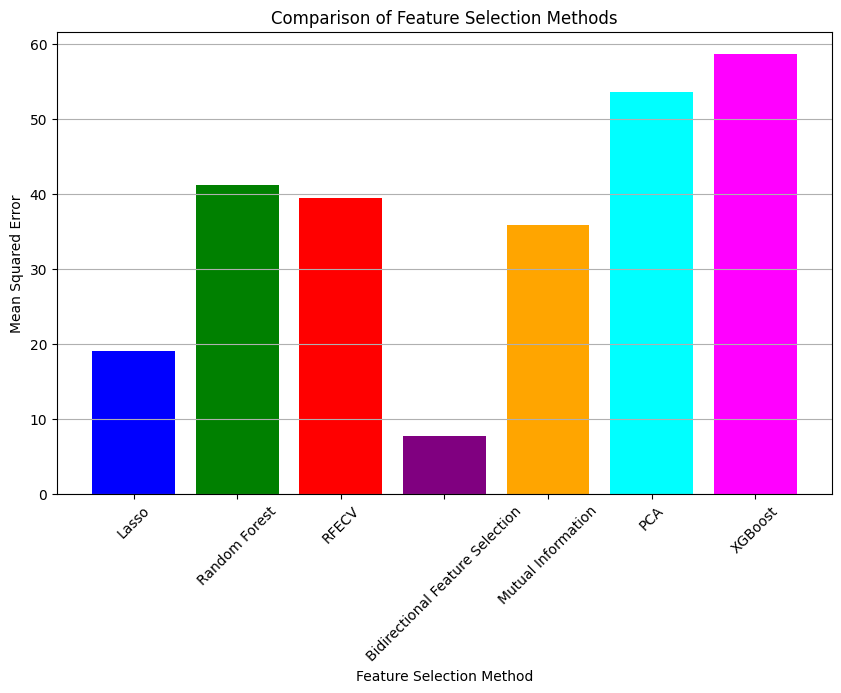

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta'])
plt.xlabel('Feature Selection Method')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Feature Selection Methods')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

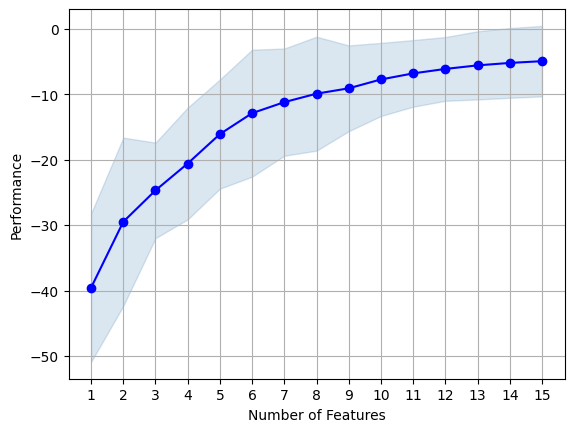

[20, 42, 1097, 1426, 1835, 1867, 2328, 2569, 2627, 2693, 3129, 3184, 3306, 3519, 3770]


In [7]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
model = LinearRegression()
sfs = SFS(model,
              k_features=15,
              forward=True,
              floating=True,
              scoring='neg_mean_squared_error',
              cv=5)
sfs = sfs.fit(X, y)
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

selected_feature_names = list(sfs.k_feature_names_)
selected_feature_indices = list(sfs.k_feature_idx_)
# dataset with feature selected
selected_feature_names.append('EDC_delta13C')
print(selected_feature_indices)



In [8]:
features = list(sfs.k_feature_names_)
print("Selected features by Bidirectional Feature Selection:", features)
data = pd.DataFrame(X[:, sfs.k_feature_idx_], columns=features)
print("New dataset with selected features:")
print(data.head())

Selected features by Bidirectional Feature Selection: ['20', '42', '1097', '1426', '1835', '1867', '2328', '2569', '2627', '2693', '3129', '3184', '3306', '3519', '3770']
New dataset with selected features:
    20   42  1097  1426  1835  1867  2328  2569  2627  2693  3129  3184  3306  \
0  0.0  0.0   0.0   3.0   0.0   0.0   7.0   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.0  0.0   1.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   
2  1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  16.0   0.0   
3  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0   0.0   
4  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   3.0   0.0   

   3519  3770  
0   0.0   0.0  
1   0.0   0.0  
2   0.0   0.0  
3   0.0   0.0  
4   0.0   0.0  


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np





print(y)
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(data)
y_scaler = preprocessing.MinMaxScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
print(y_scaled)
y = np.array(y, dtype=np.float64)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


[-16.611 -19.4895 -22.5635 -7.9655 -16.0405 -12.611 -22.7975 -14.489
 -13.2645 -13.6955 -11.126 -10.8295 -11.5165 -29.2175 -17.828 -15.126
 -28.7845 -26.8755 -21.3275 -22.7495 -23.707 -19.913 -27.0065 -16.777
 -10.966 -11.05 -13.211 -15.2825 -24.1515 -23.7415 -17.754 -36.5145
 -32.7345 -18.227 -16.3145 -17.5075 -18.199]
[[0.69716978]
 [0.59634313]
 [0.4886686 ]
 [1.        ]
 [0.71715297]
 [0.83727976]
 [0.48047217]
 [0.77149813]
 [0.8143893 ]
 [0.79929244]
 [0.8892956 ]
 [0.89968125]
 [0.87561736]
 [0.25559564]
 [0.65454131]
 [0.74918561]
 [0.27076255]
 [0.33763004]
 [0.53196259]
 [0.48215349]
 [0.44861466]
 [0.58150898]
 [0.33304144]
 [0.69135521]
 [0.8949    ]
 [0.89195769]
 [0.81626327]
 [0.74370381]
 [0.43304494]
 [0.44740621]
 [0.65713335]
 [0.        ]
 [0.13240394]
 [0.64056534]
 [0.70755543]
 [0.66576763]
 [0.64154611]]


In [10]:
from keras.models import Sequential
from keras.layers import GRU, Dense
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad, Ftrl
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.losses import Huber
model = Sequential()
model.add(GRU(units=128, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer = Adagrad(learning_rate=0.01), loss='mean_squared_error')
model.summary()
history = model.fit(X_train, y_train, epochs=500, batch_size=1, validation_data=(X_test, y_test))

2024-07-26 12:42:50.799196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 12:42:50.799324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 12:42:51.117473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,433 (197.00 KB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1544 - val_loss: 0.0450
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0819 - val_loss: 0.0481
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0759 - val_loss: 0.0485
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 - val_loss: 0.0403
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0658 - val_loss: 0.0443
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0546 - val_loss: 0.0391
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - val_loss: 0.0413
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0696 - val_loss: 0.0423
Epoch 9/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.0394
Epoch 10/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0744 - val_loss: 0.0375
Epoch 11/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - val_loss: 0.0412
Epoch 12/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

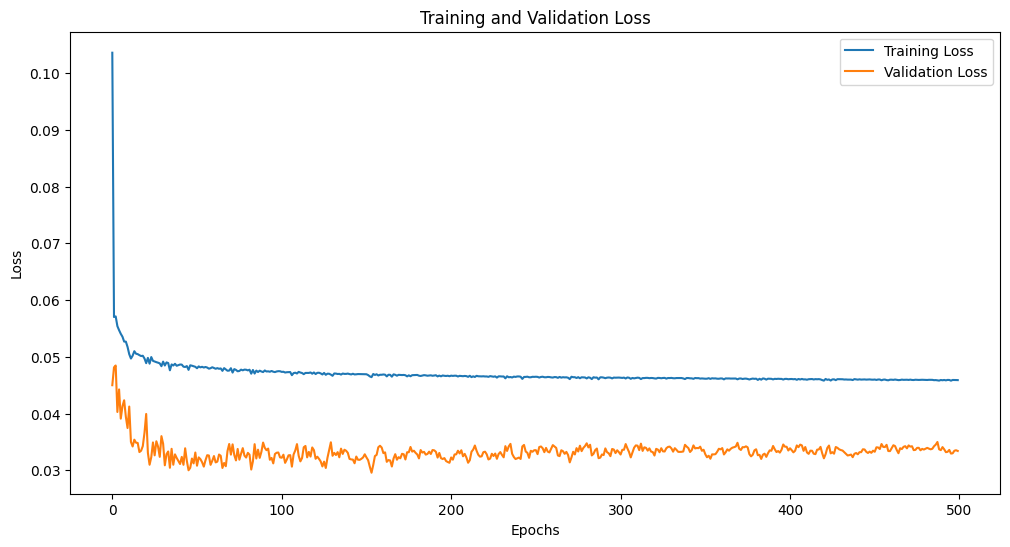

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predictions and Real Values:
Sample 0: Predicted = -20.379655838012695, Real = -16.611
Sample 1: Predicted = -20.11651611328125, Real = -19.4895
Sample 2: Predicted = -18.017536163330078, Real = -22.5635
Sample 3: Predicted = -17.699012756347656, Real = -7.9655
Sample 4: Predicted = -18.315073013305664, Real = -16.0405
Sample 5: Predicted = -17.713882446289062, Real = -12.611
Sample 6: Predicted = -20.096071243286133, Real = -22.7975
Sample 7: Predicted = -13.469355583190918, Real = -14.489
Sample 8: Predicted = -17.580631256103516, Real = -13.2645
Sample 9: Predicted = -20.253311157226562, Real = -13.6955
Sample 10: Predicted = -20.31969451904297, Real = -11.126
Sample 11: Predicted = -13.632638931274414, Real = -10.8295
Sample 12: Predicted = -18.76044464111328, Real = -11.5165
Sample 13: Predicted = -17.83660125732422, Real = -29.2175
Sample 14: Predicted = -16.037395477294922, Real = -17.828
Sample 15: Predicted = -15.468184471130371, Real = -

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

X_all = np.expand_dims(X_scaled, axis=2)
predictions = model.predict(X_all)
predictions_inverse = y_scaler.inverse_transform(predictions)
print("Predictions and Real Values:")
for i, (predicted, real) in enumerate(zip(predictions_inverse, y)):
    print(f"Sample {i}: Predicted = {predicted[0]}, Real = {real}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Fold MSE: 0.03363880324443002


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Fold MSE: 0.06313086329304057


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Fold MSE: 0.0668530110687394


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Fold MSE: 0.04177242528242343


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Fold MSE: 0.03198356976857626
Mean Squared Error across folds: 0.04747573453144194
True values and Predicted values:
True: 0.7171529650775856, Predicted: 0.6382462978363037
True: 0.4804721706539632, Predicted: 0.5773908495903015
True: 0.2555956425794246, Predicted: 0.6537899374961853
True: 0.3376300395810711, Predicted: 0.5925295948982239
True: 0.8919576867841253, Predicted: 0.9672048687934875
True: 0.8162632666643312, Predicted: 0.807589054107666
True: 0.44740621387789403, Predicted: 0.5666189193725586
True: 0.6657676275876562, Predicted: 0.5657206177711487
True: 0.8143892955970435, Predicted: 0.6671226024627686
True: 0.7992924445689865, Predicted: 0.5555164813995361
True: 0.8756173596273072, Predicted: 0.6150711178779602
True: 0.7491856107044028, Predicted: 0.7134068012237549
True: 0.2707625486006513, Predicted: 0.6066998243331909
True: 0.48215349049003453, Predicted: 0.5560408234596252
True: 0.8948999964972502, Predicted: 0.9097487926483154
True

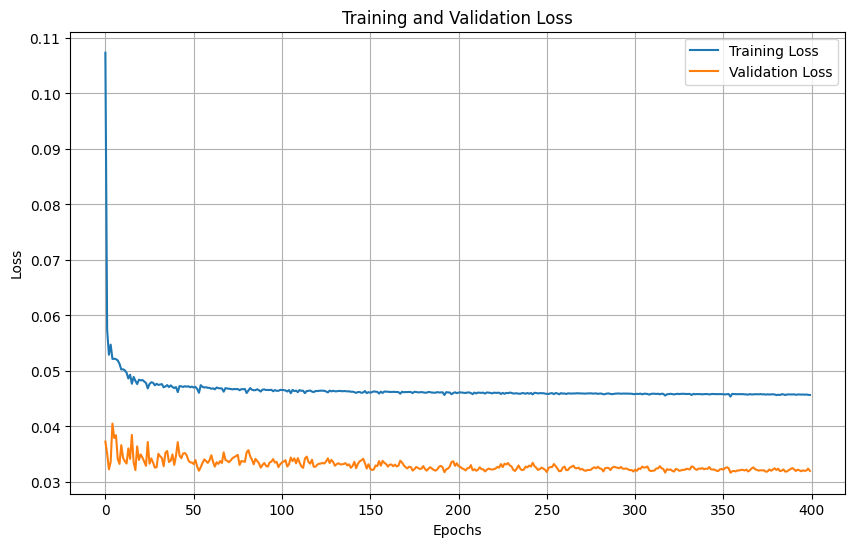

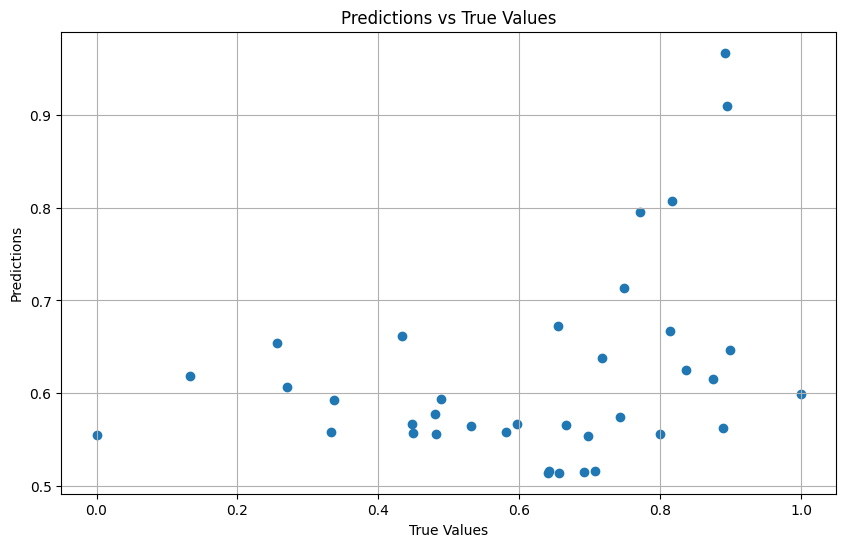

In [12]:
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
all_true_values = []
all_predictions = []


for train_index, val_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_scaled[train_index], y_scaled[val_index]
    
    model = Sequential()
    model.add(GRU(units=128, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

    model.compile(optimizer=Adagrad(learning_rate=0.01), loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=400, batch_size=1, validation_data=(X_val, y_val), verbose=0)

    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)
    
    all_true_values.extend(y_val.flatten())
    all_predictions.extend(y_pred.flatten())
    print(f"Fold MSE: {mse}")


mean_mse = np.mean(mse_scores)
print(f"Mean Squared Error across folds: {mean_mse}")


print("True values and Predicted values:")

for true_val, pred_val in zip(all_true_values, all_predictions):
    print(f"True: {true_val}, Predicted: {pred_val}")


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(all_true_values, all_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predictions vs True Values")
plt.grid()
plt.show()


In [13]:
all_true_values = np.array(all_true_values).reshape(-1, 1)
all_predictions = np.array(all_predictions).reshape(-1, 1)
y_test_original = y_scaler.inverse_transform(all_true_values)
y_pred_original = y_scaler.inverse_transform(all_predictions)
print("true values and Predicted values:")
for true_val, pred_val in zip(y_test_original.flatten(), y_pred_original.flatten()):
    print(f"True: {true_val}, Predicted: {pred_val}")

true values and Predicted values:
True: -16.0405, Predicted: -18.2932071685791
True: -22.7975, Predicted: -20.030569076538086
True: -29.217500000000005, Predicted: -17.849451065063477
True: -26.8755, Predicted: -19.598373413085938
True: -11.05, Predicted: -8.90176773071289
True: -13.211000000000002, Predicted: -13.458640098571777
True: -23.7415, Predicted: -20.338096618652344
True: -17.5075, Predicted: -20.36374282836914
True: -13.264499999999998, Predicted: -17.46881675720215
True: -13.6955, Predicted: -20.655059814453125
True: -11.5165, Predicted: -18.954835891723633
True: -15.126, Predicted: -16.147449493408203
True: -28.7845, Predicted: -19.19382667541504
True: -22.7495, Predicted: -20.640090942382812
True: -10.966, Predicted: -10.542081832885742
True: -32.7345, Predicted: -18.85855484008789
True: -16.611, Predicted: -20.710899353027344
True: -19.4895, Predicted: -20.350086212158203
True: -12.610999999999999, Predicted: -18.672269821166992
True: -10.8295, Predicted: -18.04724884033